In [ ]:
'''
This script runs a simple LSTM model on a single columns (XLocation or YLocation)
and predict k time steps in the future (t+1, t+2...t+k)
The testing activates the droupout in order to generate multiple different outputs
and then calculate the mean and standard deviation
https://fairyonice.github.io/Measure-the-uncertainty-in-deep-learning-models-using-dropout.html
'''


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
import sys
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import load_model



Using TensorFlow backend.


In [2]:
class KerasDropoutPrediction(object):
    
    def __init__(self, model):
        self.f = K.function(
            [model.layers[0].input,
             K.learning_phase()],
            [model.layers[-1].output])
        
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
        result = np.array(result).reshape(n_iter, len(x)).T
        
        #mean = result.mean(axis=0)
        #uncertainty = result.var(axis=0)
        #print("Mean:", mean, "Uncertainty:", uncertainty)
        #mean = np.mean(result)
        #std = np.std(result)
        
        return result
        
        


In [3]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()


In [4]:
def plot_prediction_ranges(x, y_true, y_pred, y_lower, y_upper, std, std_label):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    label4 = "Lower bound"
    label5 = "Upper bound"
    
    title = "Predictions v.s. true values ("+ str(std) \
            + " std. deviation, "+ std_label+"% )"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.plot(range(len(x), len(x) + len(y_pred)),y_lower, "+--r", label=label4)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_upper, "*--r", label=label5)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.show()    


In [5]:
def size_per_targets(data):
    #print("Total: ", data.shape[0])
    sizes = data.groupby(['id', 'file_id']).size()
    #print(sizes)
    #print(type(sizes))
    #print("Total:",sum(list(sizes)))

    return list(sizes)


In [38]:
def generate_input_data(data, sizes, train_len, target_seq, predict_k):
    targets = len(sizes)
    start = 0
    sequences = []
    X = []
    y = []

    for i, size in enumerate(sizes):
        print("Chunk", i+1)
        end = start + size
        print("Size of block %d, Range: %d-%d" % (size, start, end))
        temp_df = data.iloc[start:end]
        
        values = temp_df.iloc[:,-target_seq].values
        for i in range(train_len, len(values)):
            seq = values[i-train_len:i]
            
            sequences.append(seq)
                   
        # update start
        start = start + size
    
    sequences = np.array(sequences)    
    print("[INFO] Sequences generated:", len(sequences))
    
    #X = sequences[:,:-target_seq]
    X = sequences[:,:-predict_k]
    y = sequences[:,-predict_k:]
    ##print(sequences[0])
    ##print(X[0])
    ##print(y[0])

    return X, y




# MAIN   


## Load the data

In [7]:
filename = 'data/AllData.csv'
data = pd.read_csv(filename)
print(data.shape)

print(list(data.columns))


(500050, 18)
['id', 'file_id', 'Pn', 'Pe', 'h', 'Va', 'Phi', 'Theta', 'Chi', 'Psi', 'Vg', 'Azimuth', 'Elevation', 'XPixel', 'YPixel', 'ZValue', 'XLocation', 'YLocation']


## Generate the input data


#### Defining Parameters


In [11]:
column_of_interest = 'XLocation'
input_seq = 10
target_seq = 1                      # Forming the data, get 11 instances, 10 input, 1 output.  
predict_k = 5                       # predict k time steps in the future
#train_len = input_seq + target_seq
train_len = input_seq + predict_k
instance_len = train_len + predict_k-1    # 10 history + 1 (t+1) + 4 (t+4)


target = 0                          # 0 = AllTargets, 1=Only Target1, 2=Only target2, and so forth.

test_percentage = 0.2       
rand_test = True            # Picking randomly instances for the test set. Not the last test_percentage

dropout = .4
batch_size = 64
neurons = 64
epochs = 5

k_test_instances = 150       # number of randomly chosen instances to test
p_instances_to_plot = 5         # number of randomly chosen instances to show the plot
n_results = 50              # Number of predictions for the dropout. Number of iterations for the normal distribution

# By the central limit theorem, at least we need a sample of n>=30

model_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout.h5"
scaler_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout"


## Generate input data


In [47]:
# -1 is All data, else is the target id

if target != 0:
    input_data = data[data['id'] == target]
else:
    input_data = data

# Take only the column of interest
input_data = input_data[['id', 'file_id', column_of_interest]]
columns = input_data.columns

# We need to generate the sequences based on the id and file_id
sizes = size_per_targets(input_data)
X, y = generate_input_data(input_data, sizes, train_len, target_seq, predict_k)
print("X shape:",X.shape)



Chunk 1
Size of block 10001, Range: 0-10001
Chunk 2
Size of block 10001, Range: 10001-20002
Chunk 3
Size of block 10001, Range: 20002-30003
Chunk 4
Size of block 10001, Range: 30003-40004
Chunk 5
Size of block 10001, Range: 40004-50005
Chunk 6
Size of block 10001, Range: 50005-60006
Chunk 7
Size of block 10001, Range: 60006-70007
Chunk 8
Size of block 10001, Range: 70007-80008
Chunk 9
Size of block 10001, Range: 80008-90009
Chunk 10
Size of block 10001, Range: 90009-100010
Chunk 11
Size of block 10001, Range: 100010-110011
Chunk 12
Size of block 10001, Range: 110011-120012
Chunk 13
Size of block 10001, Range: 120012-130013
Chunk 14
Size of block 10001, Range: 130013-140014
Chunk 15
Size of block 10001, Range: 140014-150015
Chunk 16
Size of block 10001, Range: 150015-160016
Chunk 17
Size of block 10001, Range: 160016-170017
Chunk 18
Size of block 10001, Range: 170017-180018
Chunk 19
Size of block 10001, Range: 180018-190019
Chunk 20
Size of block 10001, Range: 190019-200020
Chunk 21
Siz

### Getting train, test data

In [69]:

# If we select the train and test randomly
if rand_test:
    print("Randomly picking train, test dataset")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, 
                                                        shuffle=False, random_state=42)
# Else, select the last % part as testing
else:
    print("Train, test split based on percentage")
    test_size = int(X.shape[0] * test_percentage)
    train_size = int(X.shape[0] - test_size)
    print("Train size:", train_size)
    X_train = X[:train_size, :]
    X_test = X[train_size:, :]
    
    y_train = y[:train_size]
    y_test = y[train_size:]    

print("X Train size=", X_train.shape[0])
print("X Test size=",X_test.shape[0])
print("y Train size=", y_train.shape[0])
print("y Test size=",y_test.shape[0])

#print(X_train[0:2])
#print(y_train[0:2])
#print()
#print(X_test[0:2])
#print(y_test[0:2])



Randomly picking train, test dataset
X Train size= 399440
X Test size= 99860
y Train size= 399440
y Test size= 99860


### Scale the Input Data


In [70]:
# fit the values between 0 and 1
scaler_object = MinMaxScaler()

scaler_object.fit(X_train)

scaled_X_train =  scaler_object.transform(X_train)
scaled_X_test =  scaler_object.transform(X_test)

train_X = scaled_X_train.reshape((scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
test_X = scaled_X_test.reshape((scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))


#print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

train_X = train_X.reshape((scaled_X_train.shape[0], scaled_X_train.shape[1], 1))

test_X = test_X.reshape((scaled_X_test.shape[0], scaled_X_test.shape[1], 1))
print("(Instances,Sequence,Features)")
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)
print("** At this point the y_train and y_test have the future true points.")


(Instances,Sequence,Features)
(399440, 10, 1) (399440, 5) (99860, 10, 1) (99860, 5)
** At this point the y_train and y_test have the future true points.


## Create the LSTM model


In [71]:
### If it is already saved then do not run it again, it takes time
# design network
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(neurons))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

# fit network
# using y_train[:,0] just to get the first column of predicting k
history = model.fit(train_X, y_train[:,0], epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, y_test[:,0]), verbose=2, shuffle=False)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________

### Plot the loss

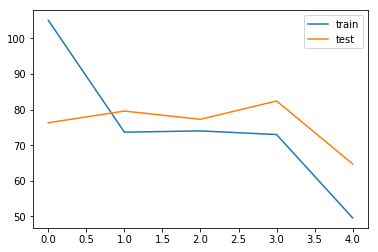

dict_keys(['loss', 'val_loss'])


In [72]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

print(history.history.keys())


### Save the model and scaler


In [ ]:
print(model_filename)
model.save(model_filename)
print(scaler_filename)
dump(scaler_object, open(scaler_filename, 'wb'))


### Load the model


In [118]:
print("Loading the model:", model_filename)
model = load_model(model_filename)
print("Loading the scaler:", scaler_filename)
scaler_object = load(open(scaler_filename, 'rb'))


Loading the model: models/model_lstm_XLocation_10_timesteps_dropout.h5
Loading the scaler: models/model_lstm_XLocation_10_timesteps_dropout


## Make predictions with dropout
As it will take a lot of time do the prediction for all the test set
I pick a random number of test instances

### Pick some random indices

In [119]:
indices = np.random.choice(range(test_X.shape[0]), replace=False, size=k_test_instances)
print(indices)



[32206 43409 17279 78130 63324  6362 46574  3929 87110 64066 16486 11833
 94874 10470 82692 32589 78511 12359 25548 98912 85881 17144 95258 38350
 29973 24895 55778  6600 14480 27589 28769  9289 25813 81188 33499 21039
 54308 54381  5205  1530 26828 88428 35782 38576 52049 44111 62750  6384
 57396 15646 44069 69065 37202 29934 55024 63196 32806  8882 66994 79989
   921 15684 73937  4218 98192 13886 85417 51172  8446 32841 70230 91084
 88885 19453 36187 35283 65511 75813 27089 31261 62557 63878 98515  9911
 46249 35733 28680 88400 98666 15450 46773  6604 47855 35020 17415 55739
 16907  5969 45911 61517 36910  5548 52172 14184 45807 36827 38086 29218
 40367 50568 79982 52969 34117 48967 22725 90732  2263 27008 23545 77391
 76156 88235 43935 29518 27459 37414  7968 88887 75796 73807 19070 76581
 74080 95313 20947 69536 81561 93657 50740 72393 53447 38145 18297 11618
 79970 98893 32774 63663 61494 31744]


## Predictions for the Random test indices

In [120]:

kdp = KerasDropoutPrediction(model)

y_true = []
y_hat = []
y_hat_std = []
for i, index in enumerate(indices):
    x_test = test_X[index]
    #y_true.append(y_test[index])
    y_true.append(y_test[index][0])
    
    result = kdp.predict([x_test], n_results)
    #print(result.flatten())
    #print(result.shape)
    yhat_mean = np.mean(result)
    yhat_std = np.std(result)
    print(i+1, '\t', index, '\tMean:', yhat_mean, 'Std:', yhat_std, 'y',y_test[index][0])
    y_hat.append(yhat_mean)
    y_hat_std.append(yhat_std)

print(y_true)
print(len(y_true))
print(y_hat)
print(len(y_hat))
print(y_hat_std)
print(len(y_hat_std))


1 	 32206 	Mean: 197.70819 Std: 31.354603 y 262.9
2 	 43409 	Mean: 180.27916 Std: 34.44365 y 176.35
3 	 17279 	Mean: 189.3981 Std: 27.38728 y 185.25
4 	 78130 	Mean: 203.4732 Std: 35.596375 y 350.1
5 	 63324 	Mean: 186.63695 Std: 31.697489 y 179.2
6 	 6362 	Mean: 168.8381 Std: 33.28937 y 131.55
7 	 46574 	Mean: 175.6356 Std: 31.546629 y 149.9
8 	 3929 	Mean: 171.94438 Std: 37.918262 y 153.15
9 	 87110 	Mean: 199.8261 Std: 36.516598 y 250.05
10 	 64066 	Mean: 171.52928 Std: 32.92078 y 149.9
11 	 16486 	Mean: 196.74318 Std: 27.796495 y 224.9
12 	 11833 	Mean: 199.15936 Std: 27.75467 y 242.85
13 	 94874 	Mean: 166.70178 Std: 30.751627 y 149.9
14 	 10470 	Mean: 187.2685 Std: 28.950533 y 174.7
15 	 82692 	Mean: 204.2872 Std: 29.417921 y 250.05
16 	 32589 	Mean: 197.5219 Std: 32.078575 y 282.05
17 	 78511 	Mean: 192.7587 Std: 27.62908 y 350.1
18 	 12359 	Mean: 198.28975 Std: 37.631443 y 230.95
19 	 25548 	Mean: 206.39832 Std: 31.558096 y 329.25
20 	 98912 	Mean: 151.31487 Std: 26.367975 y 49

### Calculating Prediction Ranges (lower and upper bounds)


In [121]:
def get_ranges(y_hat, y_hat_std, num_stds=1):
    y_hat_lowers = []
    y_hat_uppers = []

    for i in range(len(y_hat)):
        point = y_hat[i]
        std = y_hat_std[i]
        lower = point - (num_stds * std)
        upper = point + (num_stds * std)
        
        y_hat_lowers.append(lower)
        y_hat_uppers.append(upper)
        
    
    return y_hat_uppers, y_hat_lowers


With std deviation

In [122]:
std_dev = 1
std_dev_labels = {1:'0.68', 2:'0.95', 3:'0.997'}


In [123]:
print("Results with %d standad deviation" % std_dev)
y_hat_uppers, y_hat_lowers = get_ranges(y_hat, y_hat_std, std_dev)
print("Upper:\t", y_hat_uppers)
print("Mean:\t",y_hat)
print("Truth:\t", y_true)
print("Lower:\t",y_hat_lowers)



Results with 1 standad deviation
Upper:	 [229.06279373168945, 214.72280883789062, 216.78538131713867, 239.069580078125, 218.33443641662598, 202.1274757385254, 207.1822338104248, 209.86264419555664, 236.34269332885742, 204.4500617980957, 224.53967475891113, 226.91403198242188, 197.4534091949463, 216.21902656555176, 233.70512199401855, 229.60047149658203, 220.3877773284912, 235.92119216918945, 237.95641136169434, 177.68284034729004, 223.77130126953125, 224.68890380859375, 210.82454299926758, 235.1698760986328, 205.5603790283203, 234.76091384887695, 234.55421447753906, 204.14752578735352, 217.48478317260742, 233.40376663208008, 235.86255645751953, 182.79177284240723, 229.2422161102295, 238.27488327026367, 229.71320343017578, 223.39628791809082, 228.03471565246582, 230.89138412475586, 203.23858451843262, 236.68991088867188, 230.85124588012695, 229.54956245422363, 226.23904418945312, 227.0454387664795, 233.01688385009766, 214.68585968017578, 222.40332794189453, 223.13322830200195, 247.01930

## Evaluate the model
from random samples


In [124]:
# make a prediction
#print("test_X shape", test_X.shape)
#yhat = model.predict(test_X)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_hat))
print('Test RMSE: %.3f' % rmse)
mae = np.sqrt(mean_absolute_error(y_true, y_hat))
print('Test MAE: %.3f' % mae)


Test RMSE: 79.369
Test MAE: 7.654


## Comparing results

In [ ]:
# Picked k random test instances
#t_X = test_X.reshape(test_X.shape[0], test_X.shape[1])
##t_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])


In [125]:
print(indices)

plot_indices = np.random.choice(list(indices), replace=False, size=p_instances_to_plot)
print(plot_indices)

plot_indices_idx = []
for p in plot_indices:
    idx = list(indices).index(p)
    plot_indices_idx.append(idx)
    
print(plot_indices_idx)


[32206 43409 17279 78130 63324  6362 46574  3929 87110 64066 16486 11833
 94874 10470 82692 32589 78511 12359 25548 98912 85881 17144 95258 38350
 29973 24895 55778  6600 14480 27589 28769  9289 25813 81188 33499 21039
 54308 54381  5205  1530 26828 88428 35782 38576 52049 44111 62750  6384
 57396 15646 44069 69065 37202 29934 55024 63196 32806  8882 66994 79989
   921 15684 73937  4218 98192 13886 85417 51172  8446 32841 70230 91084
 88885 19453 36187 35283 65511 75813 27089 31261 62557 63878 98515  9911
 46249 35733 28680 88400 98666 15450 46773  6604 47855 35020 17415 55739
 16907  5969 45911 61517 36910  5548 52172 14184 45807 36827 38086 29218
 40367 50568 79982 52969 34117 48967 22725 90732  2263 27008 23545 77391
 76156 88235 43935 29518 27459 37414  7968 88887 75796 73807 19070 76581
 74080 95313 20947 69536 81561 93657 50740 72393 53447 38145 18297 11618
 79970 98893 32774 63663 61494 31744]
[35782 25813 55739 29934 48967]
[42, 32, 95, 53, 113]


### Plot some tests

35782
25813
55739
29934
48967


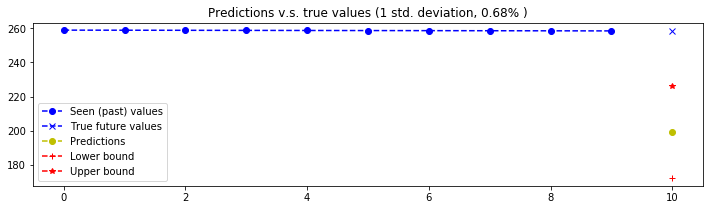

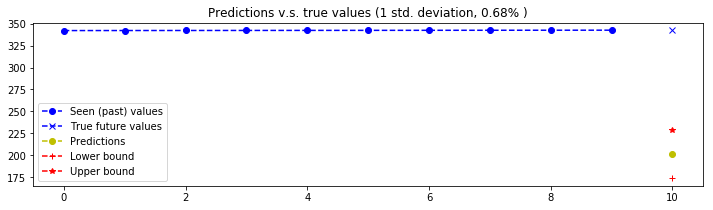

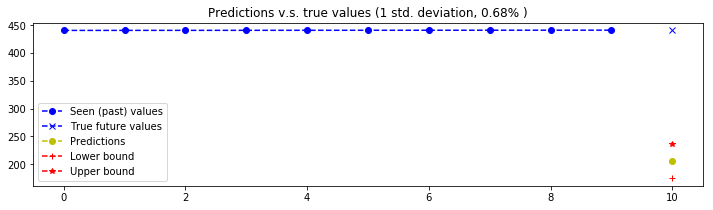

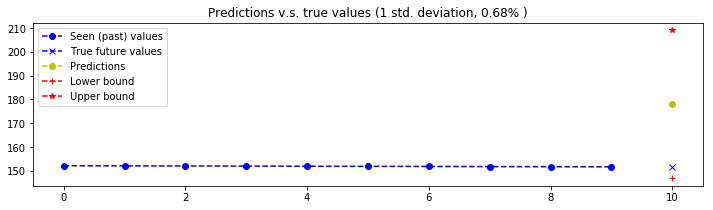

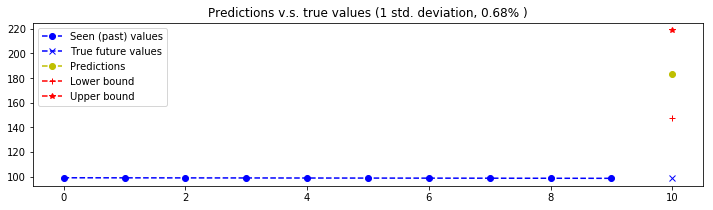

In [126]:
#indices = np.random.choice(range(t_X.shape[0]), replace=False, size=3)
for i, index in enumerate(plot_indices):
    print(index)
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    y_idx = list(indices).index(index)
    
    plot_prediction_ranges(test_X_rescaled[0], [y_test[index][0]], 
                           [y_hat[y_idx]], [y_hat_lowers[y_idx]],[y_hat_uppers[y_idx]],
                           std_dev, std_dev_labels[std_dev])



## Predicting k steps in the future


In [127]:
all_predictions = []
all_deviations = []
for index in plot_indices:
    print("~"*50)
    print("~"*50)
    print("Predictions for index:", index)
    x_test = np.asarray([test_X[index]])    
    input = x_test
    print("input shape", input.shape)
    
    predictions = []
    std_deviations = []
    for i in range(predict_k):
        print("Pred ", i+1)    
        print("Input shape:", input.shape)
        window = input.reshape(x_test.shape[0], x_test.shape[1])
        ##print("Window")
        ##print(window)
        ##print("window shape",window.shape)
        
        # This will convert the values to Location values
        window_rescaled = scaler_object.inverse_transform(window)
        print("Window rescaled")
        print(window_rescaled)
        print("window rescaled shape:",window_rescaled.shape)
        
        result = kdp.predict(input, n_results)
        #print(result.flatten())
        #print(result.shape)
        yhat_mean = np.mean(result)
        yhat_std = np.std(result)
        
        #yhat = model.predict(input)
        yhat = yhat_mean
        print("Pred ", i+1, ":", yhat)
        
        #predictions.append(yhat[0][0])    
        predictions.append(yhat)
        print('yhat', yhat)
        ##print(type(yhat))
        ##print(type(window_rescaled))

        std_deviations.append(yhat_std)
        
        input = np.append(window_rescaled[:,1:], yhat)
        print("New window:", input)
        print("New window shape", input.shape)
 
        input = input.reshape(1, input.shape[0], window.shape[0])
        ##print("New new input shape:", input.shape)
        ##print(input)
        # This will convert the location values to scaled values
        
        input = input.reshape(1, input.shape[1])
        input = scaler_object.transform(input)
        ##print("New scaled input")
        ##print(input)
        ##print("New scaled input shape", input.shape)
        
        input = input.reshape(1, input.shape[1], window.shape[0])
        ##print("input shape",input.shape)
        print("#" * 50)
        
    print(predictions)
    print(std_deviations)
    
    all_predictions.append(predictions)
    all_deviations.append(std_deviations)
print()
print(all_predictions)
print(all_deviations)
      

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predictions for index: 35782
input shape (1, 10, 1)
Pred  1
Input shape: (1, 10, 1)
Window rescaled
[[258.9  258.85 258.8  258.75 258.7  258.65 258.6  258.55 258.5  258.45]]
window rescaled shape: (1, 10)
Pred  1 : 194.96266
yhat 194.96266
New window: [258.85       258.8        258.75       258.7        258.65
 258.6        258.55       258.5        258.45       194.96266174]
New window shape (10,)
##################################################
Pred  2
Input shape: (1, 10, 1)
Window rescaled
[[258.85       258.8        258.75       258.7        258.65
  258.6        258.55       258.5        258.45       194.96266174]]
window rescaled shape: (1, 10)
Pred  2 : 199.26018
yhat 199.26018
New window: [258.8        258.75       258.7        258.65       258.6
 258.55       258.5        258.45       194.96266174 199.26017761]
New window shape (10,)
########################################

### Get the ranges


In [128]:
all_uppers = []
all_lowers = []
all_means = []

print("Results with %d standard deviations" % std_dev)
for i, index in enumerate(plot_indices):
    print(i)
    y_hats = all_predictions[i]
    std_devs = all_deviations[i]
    #print(y_hats)
    #print(std_devs)
    y_uppers = []
    y_lowers = []
    y_means = []
    for j in range(len(y_hats)):
        yhat = [y_hats[j]]
        ystd = [std_devs[j]]
        #print('yhat:',yhat)
        #print('ystd:',ystd)
        
        y_hat_uppers, y_hat_lowers = get_ranges(yhat, ystd, std_dev)
        
        print("Upper:\t", y_hat_uppers[0])
        print("Mean:\t",yhat[0])
        print("Truth:\t", y_test[index][j])
        print("Lower:\t",y_hat_lowers[0])
        print()
        y_uppers.append(y_hat_uppers[0])
        y_lowers.append(y_hat_lowers[0])
        y_means.append(yhat[0])
    print()
    
    all_uppers.append(y_uppers)
    all_lowers.append(y_lowers)
    all_means.append(y_means)


Results with 1 standard deviations
0
Upper:	 228.02092361450195
Mean:	 194.96266
Truth:	 258.4
Lower:	 161.90439987182617

Upper:	 239.89064025878906
Mean:	 199.26018
Truth:	 258.35
Lower:	 158.6297149658203

Upper:	 236.53672790527344
Mean:	 204.42409
Truth:	 258.3
Lower:	 172.3114471435547

Upper:	 226.4344482421875
Mean:	 197.88855
Truth:	 258.25
Lower:	 169.3426513671875

Upper:	 229.28656578063965
Mean:	 198.1662
Truth:	 258.2
Lower:	 167.04583168029785


1
Upper:	 236.6841049194336
Mean:	 203.89824
Truth:	 342.5
Lower:	 171.11237335205078

Upper:	 240.5108413696289
Mean:	 200.55684
Truth:	 342.55
Lower:	 160.60283660888672

Upper:	 225.62317657470703
Mean:	 192.29979
Truth:	 342.6
Lower:	 158.97640228271484

Upper:	 244.78971481323242
Mean:	 211.98651
Truth:	 342.65
Lower:	 179.18330764770508

Upper:	 235.83219528198242
Mean:	 203.2392
Truth:	 342.7
Lower:	 170.64619827270508


2
Upper:	 239.18901824951172
Mean:	 201.87491
Truth:	 440.95
Lower:	 164.56079864501953

Upper:	 233.00

### Print the ranges

In [116]:
print(all_uppers)
print(all_means)
print(all_lowers)


[[336.6602897644043, 345.48779296875, 347.2418975830078, 341.4645118713379, 344.4503059387207], [250.53979110717773, 249.29387664794922, 239.16898345947266, 251.02315139770508, 259.2575225830078], [247.3182601928711, 242.4616584777832, 253.23716354370117, 240.68540573120117, 241.22148895263672], [255.7603530883789, 254.4994010925293, 243.75601959228516, 255.1558609008789, 253.79815292358398], [292.5498352050781, 292.51691818237305, 282.5337104797363, 288.3216972351074, 277.3108901977539]]
[[297.65295, 302.88547, 307.16806, 300.57446, 305.7186], [209.49347, 207.61427, 206.8136, 212.6396, 217.23152], [206.82594, 201.82964, 204.27179, 196.51355, 202.16107], [212.75719, 210.03644, 206.16461, 220.74207, 213.35033], [246.08105, 249.94783, 243.52264, 246.18382, 244.56412]]
[[258.6456184387207, 260.28314208984375, 267.09422302246094, 259.6844139099121, 266.98688888549805], [168.44714736938477, 165.9346694946289, 174.45821380615234, 174.25605392456055, 175.2055206298828], [166.33362579345703, 1

## Plot future predictions with boundaries


35782
[258.4  258.35 258.3  258.25 258.2 ]
25813
[342.5  342.55 342.6  342.65 342.7 ]
55739
[440.95 441.   441.05 441.1  441.15]
29934
[151.65 151.6  151.55 151.5  151.45]
48967
[98.55 98.5  98.45 98.4  98.35]


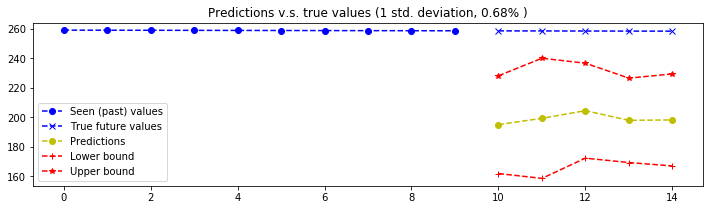

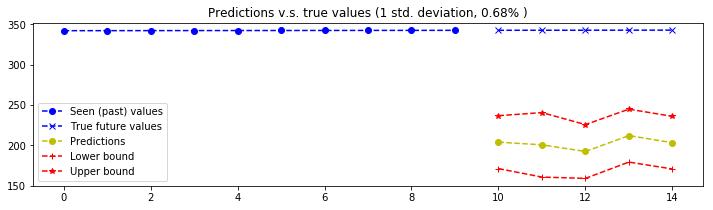

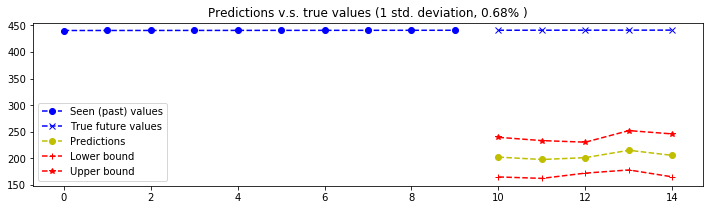

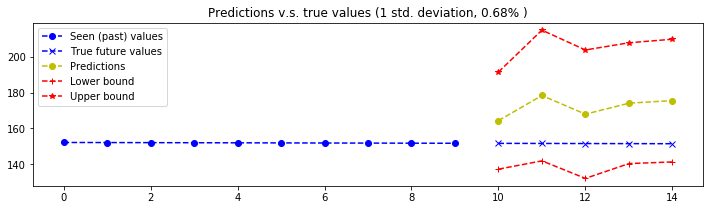

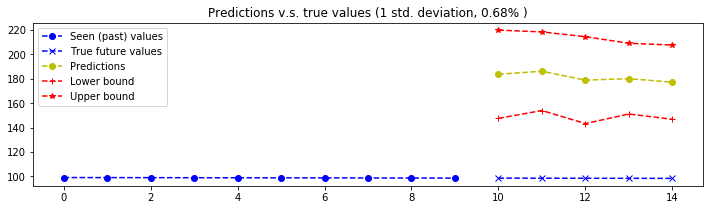

In [129]:
for i, index in enumerate(plot_indices):
    print(index)
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    y_idx = list(indices).index(index)
    
    print(y_test[index])
    plot_prediction_ranges(test_X_rescaled[0], y_test[index], 
                           all_means[i], all_lowers[i],
                           all_uppers[i],
                           std_dev, std_dev_labels[std_dev])



